<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_p24/blob/main/codigo/intro_ml/05_hyperparameters_regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Regularizacion y Validacion

Ahora estudiaremos como funciona la regularizacion, y como se ve la convergencia de los parametros.

Basado en [este codigo](https://colab.research.google.com/github/cvxgrp/cvxpy/blob/master/examples/machine_learning/ridge_regression.ipynb#scrollTo=MHUqiFdmw6-y).

In [81]:
# !pip install cvxpy
# !pip install -U scikit-learn
# !pip install pandas
# !pip install seaborn

In [82]:
import cvxpy as cp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(rc={'figure.figsize':(16,6)})

In [83]:
def fun_perdida(X, Y, beta):
    return cp.pnorm(cp.matmul(X, beta) - Y, p=2)**2

def penalizacion(beta):
    return cp.pnorm(beta, p=2)**2

def fun_objetivo(X, Y, beta, lambd):
    return fun_perdida(X, Y, beta) + lambd * penalizacion(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * fun_perdida(X, Y, beta).value

In [84]:
def generate_data(m=100, n=20, sigma=5):
    "Generates data matrix X and observations Y."
    np.random.seed(8939)
    beta_star =  np.random.lognormal(0,1,size=(n,))*5 + 2
    X = np.random.normal(10,1,size=(m, n))
    eps = np.random.normal(10,1,size=m)
    Y = X.dot(beta_star) + eps
    return X, Y , beta_star

In [85]:
import warnings

def plot_errors(train_errors, val_errors, test_errors, lambd_values):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        
        sns.lineplot(x=lambd_values, y=train_errors, label="Train error")
        sns.lineplot(x=lambd_values, y=val_errors, label="Val error")
        sns.lineplot(x=lambd_values, y=test_errors, label="Test error")
    
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    lmb_opt = val_errors.index(min(val_errors))
    lmb_opt = lambd_values[lmb_opt]
    test_opt = test_errors.index(min(test_errors))
    test_opt = lambd_values[test_opt]
    plt.axvline(lmb_opt, color='orange')
    plt.axvline(test_opt, color='g')
    plt.show()


In [86]:
import warnings

def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        for i in range(num_coeffs):
            sns.lineplot(x=lambd_values, y=[wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()


Modelo real:  
$y = X\beta + \epsilon$  
$\beta \in \mathcal{R}^n$  
 $X \in \mathcal{R}^{m \times n}$
  
Modelo $\hat{f}$ propuesto:  
$\hat{f} = X\beta_{I} + X^2\beta_{II} + X^3\beta_{III} $  


Osea estamos proponiendo un polinomio de grado 3 sin interacciones entre las varaibles.

In [173]:
m = 1000 # Obervaciones
n = 5 # Numero de varaibles relevantes
noise = 3
sigma = 5
X, Y, real_beta = generate_data(m, n, sigma)

Estas son las betas que generamos aleatoriamente, y son las reales. Recuerda que el modelo original es lineal en las X's y no utiliza ningun tipo de transformacion polinomial. Osea solo es del estilo $Y = X \beta + \epsilon$

In [174]:
real_beta

array([ 5.07228245,  3.34440183,  4.03227024,  3.73270088, 12.8893459 ])

In [175]:
df = pd.DataFrame(X)
df.columns = [f'X_{c}' for c in df.columns]
df['Y'] = Y
df.head()

,X_0,X_1,X_2,X_3,X_4,Y
0,10.247714,10.036217,10.959475,9.380227,10.797430,314.913614
1,11.205446,10.901211,8.954258,10.951961,11.292055,325.900381
2,11.840188,9.899996,8.016567,9.947959,9.376563,291.481468
3,9.355719,10.115617,10.213001,9.602692,9.530876,292.416630
4,9.585626,10.914836,10.441916,12.497298,9.914846,311.410369


In [90]:
df.corr()

,X_0,X_1,X_2,X_3,X_4,Y
X_0,1.000000,-0.003472,0.021016,0.003290,0.014344,0.340055
X_1,-0.003472,1.000000,-0.018889,-0.034395,-0.021446,0.186508
X_2,0.021016,-0.018889,1.000000,0.027672,-0.022034,0.262046
X_3,0.003290,-0.034395,0.027672,1.000000,0.000299,0.259453
X_4,0.014344,-0.021446,-0.022034,0.000299,1.000000,0.838163
Y,0.340055,0.186508,0.262046,0.259453,0.838163,1.000000


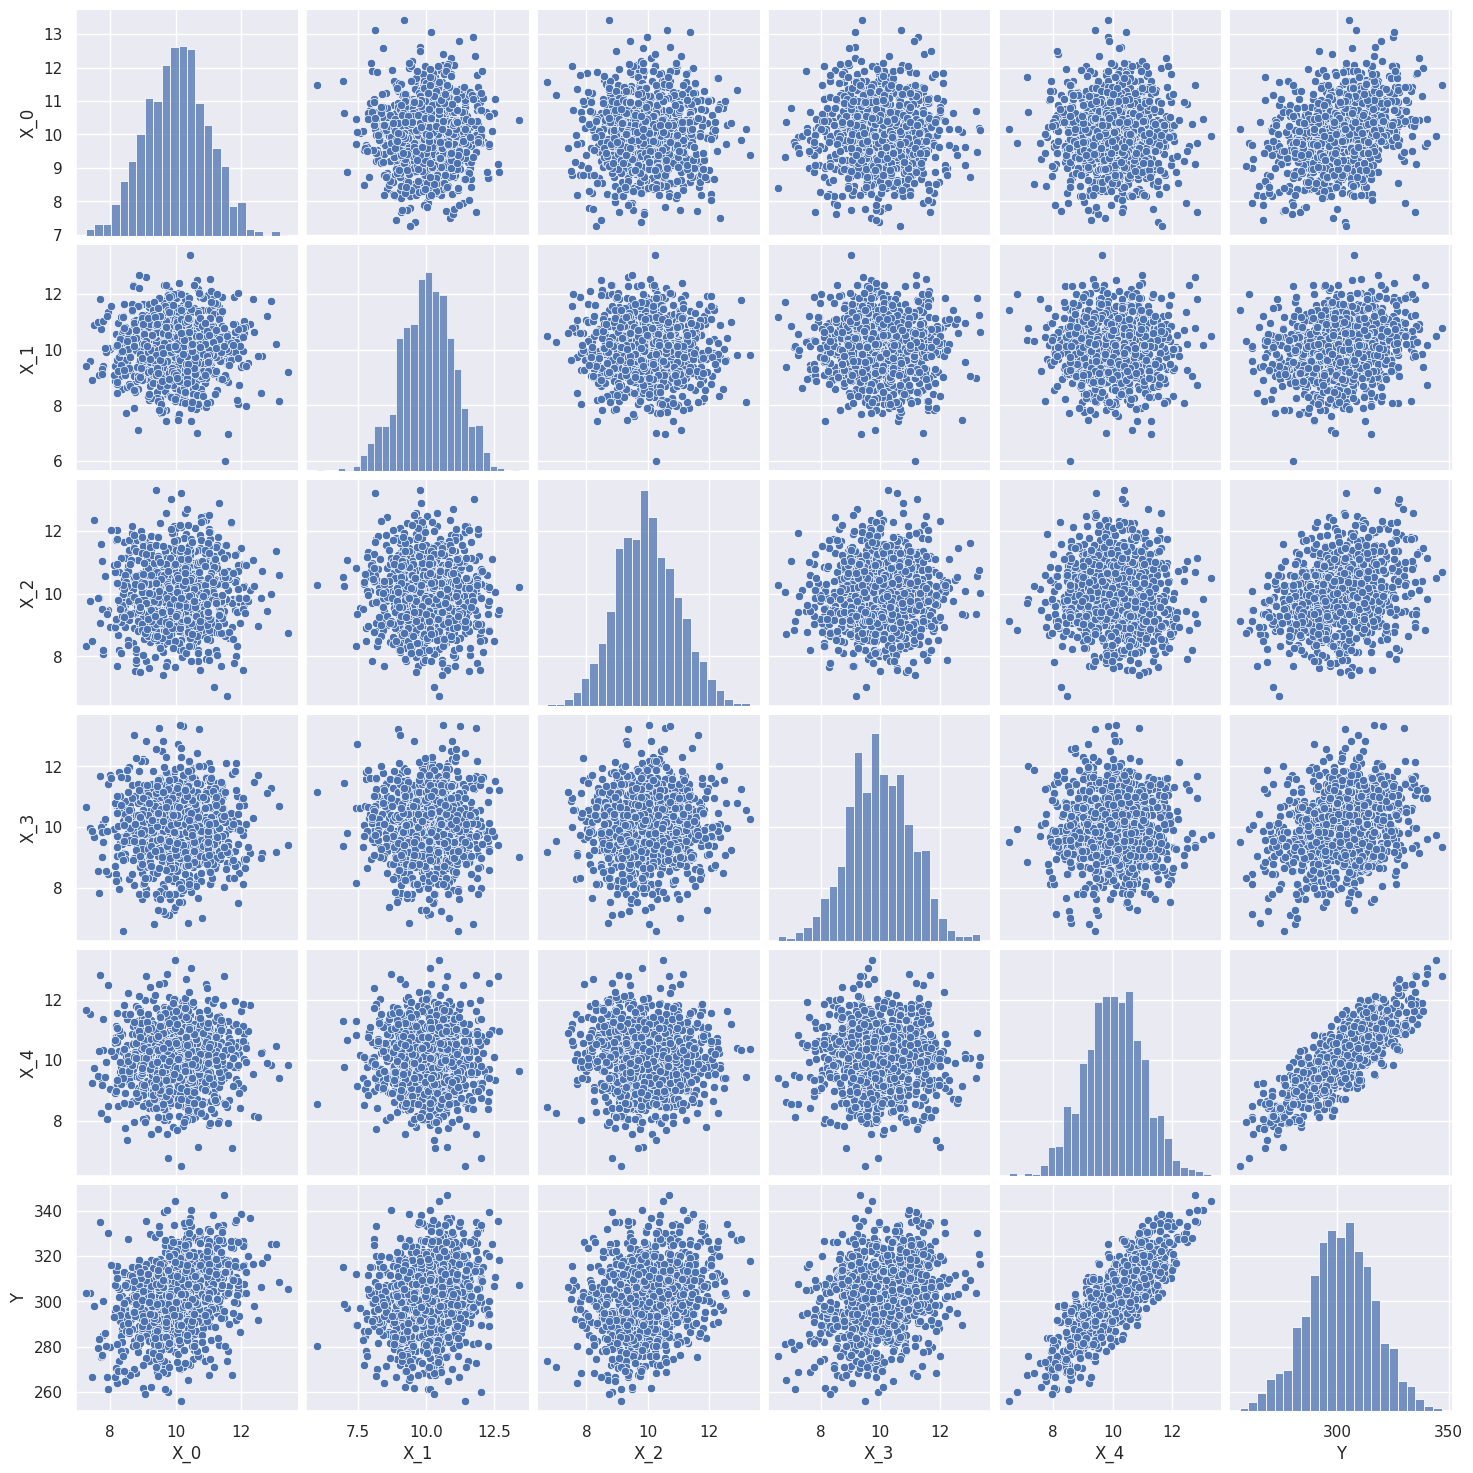

In [176]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.pairplot(df)

In [177]:
X_fe = X.copy()
grado_polinomial = 2
for p in range(2,grado_polinomial+1):
    X_fe = np.concatenate((X_fe,np.power(X[:,0:n],p)), axis=1)
real_beta_fe = np.concatenate((real_beta, np.zeros( X_fe.shape[1]-n)))
n_fe = X_fe.shape[1]


Como agregamos ingenieria de variables que realmente no estan presentes en el proceso original las betas/coeficientes/pendientes que tienen asignados deben ser cero en realidad.

In [179]:
real_beta_fe

array([ 5.07228245,  3.34440183,  4.03227024,  3.73270088, 12.8893459 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [180]:
df_fe = pd.DataFrame(X_fe)
df_fe.columns = [f'X_{c}' for c in df_fe.columns]
df_fe['Y'] = Y
df_fe.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,Y
0,10.247714,10.036217,10.959475,9.380227,10.797430,105.015640,100.725660,120.110083,87.988655,116.584492,314.913614
1,11.205446,10.901211,8.954258,10.951961,11.292055,125.562021,118.836400,80.178736,119.945450,127.510499,325.900381
2,11.840188,9.899996,8.016567,9.947959,9.376563,140.190052,98.009922,64.265354,98.961883,87.919925,291.481468
3,9.355719,10.115617,10.213001,9.602692,9.530876,87.529478,102.325709,104.305396,92.211697,90.837591,292.416630
4,9.585626,10.914836,10.441916,12.497298,9.914846,91.884223,119.133635,109.033608,156.182447,98.304169,311.410369


In [181]:
df_fe.corr()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,Y
X_0,1.000000,-0.003472,0.021016,0.003290,0.014344,0.997681,-0.000392,0.021522,0.001031,0.012482,0.340055
X_1,-0.003472,1.000000,-0.018889,-0.034395,-0.021446,-0.002371,0.997346,-0.018405,-0.030385,-0.017217,0.186508
X_2,0.021016,-0.018889,1.000000,0.027672,-0.022034,0.019794,-0.017425,0.997503,0.026590,-0.028231,0.262046
X_3,0.003290,-0.034395,0.027672,1.000000,0.000299,0.002422,-0.029746,0.028020,0.997045,-0.000782,0.259453
X_4,0.014344,-0.021446,-0.022034,0.000299,1.000000,0.016047,-0.021399,-0.017962,-0.002585,0.997397,0.838163
X_5,0.997681,-0.002371,0.019794,0.002422,0.016047,1.000000,0.000590,0.020499,-0.000018,0.014172,0.340383
X_6,-0.000392,0.997346,-0.017425,-0.029746,-0.021399,0.000590,1.000000,-0.016997,-0.025734,-0.017020,0.188648
X_7,0.021522,-0.018405,0.997503,0.028020,-0.017962,0.020499,-0.016997,1.000000,0.026672,-0.024210,0.265115
X_8,0.001031,-0.030385,0.026590,0.997045,-0.002585,-0.000018,-0.025734,0.026672,1.000000,-0.003677,0.256343
X_9,0.012482,-0.017217,-0.028231,-0.000782,0.997397,0.014172,-0.017020,-0.024210,-0.003677,1.000000,0.834382


Plateemos el problema de optimizacion:

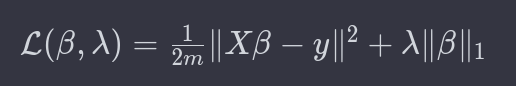

In [182]:
from tqdm import tqdm
# Split Test Train
X_t, X_test, Y_t, Y_test = train_test_split(
X_fe, Y, test_size=0.2, random_state=48)
# Split Train Validation
X_train, X_val, Y_train, Y_val = train_test_split(
X_t, Y_t, test_size=0.5, random_state=420)

# Numero de betas
beta = cp.Variable(n_fe)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(fun_objetivo(X_train, Y_train, beta, lambd)))

lambd_values = np.random.uniform(0, 1, 500)
train_errors = []
val_errors = []
test_errors = []
beta_values = []
# Resolver regresion lineal para cada lambda planteando el lagrangeano
for v in tqdm(lambd_values):
    lambd.value = v
    problem.solve(solver=cp.SCS, max_iters=5000)
    train_errors.append(mse(X_train, Y_train, beta))
    val_errors.append(mse(X_val, Y_val, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:04<00:00, 100.95it/s]


En que parte del codigo seleccione las lambdas de regularizacion para utilizar?

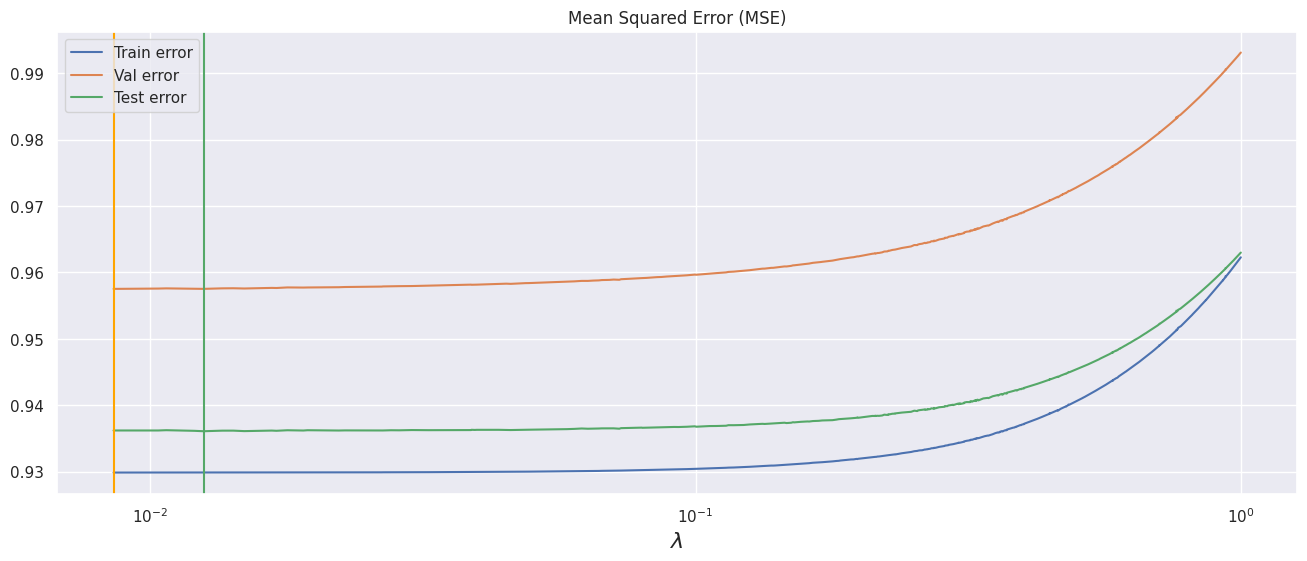

In [184]:
plot_errors(train_errors, val_errors, test_errors, lambd_values)

Dinamica de las $\beta$ dependiendo del valor de $\lambda$

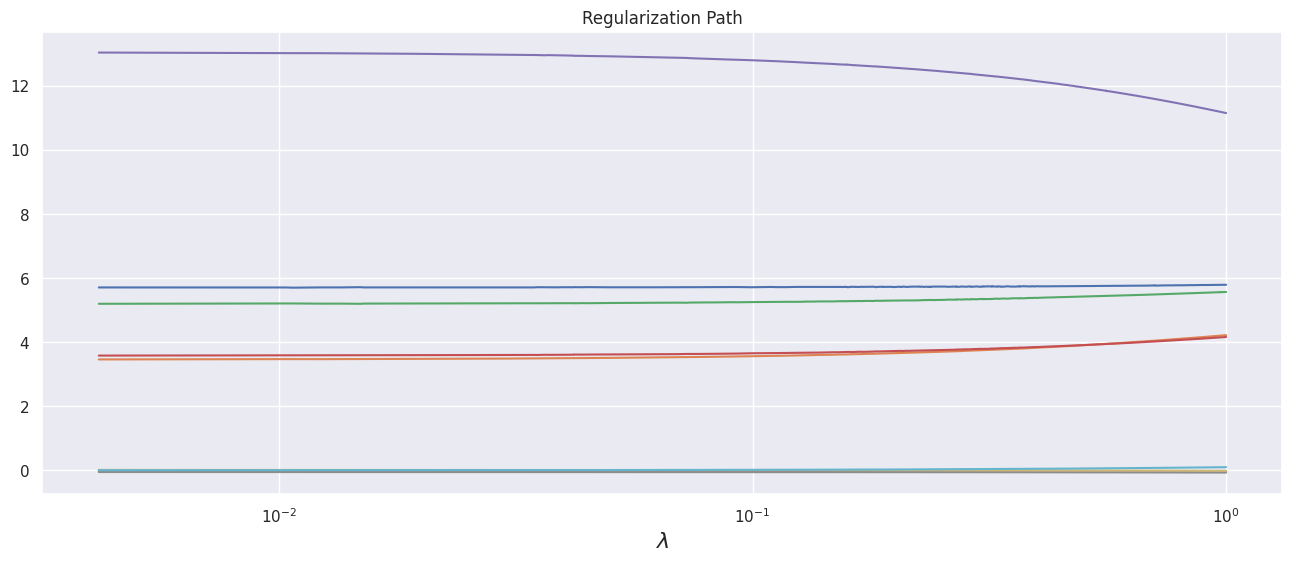

In [100]:
plot_regularization_path(lambd_values, beta_values)

$\beta^*$ optima vs. $\beta$ real

Lambda Optima: 0.008569501549295255


/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


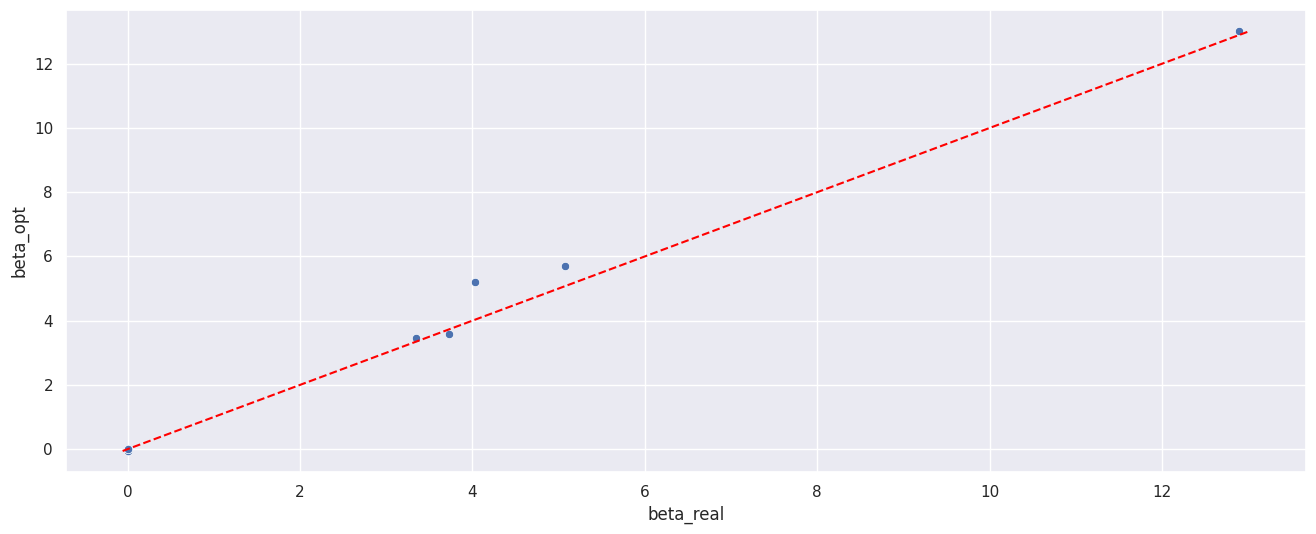

In [185]:
lmb_opt = val_errors.index(min(val_errors))
print(f'Lambda Optima: {lambd_values[lmb_opt]}')
betas = pd.DataFrame({'beta_real': real_beta_fe, 'beta_opt': beta_values[lmb_opt]})
sns.scatterplot(data=betas, y='beta_opt', x='beta_real')

# Add 45-degree line
min_val = min(betas['beta_real'].min(), betas['beta_opt'].min())
max_val = max(betas['beta_real'].max(), betas['beta_opt'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red')

plt.show()

# Regularizacion con entrenamiento

Ahora estudiemos como funciona la regularizacion en la paqueteria de `sklearn`. Para ello importamos el modelo `lasso` que en vez de tener una penalizacion cuadratica, la tiene como valor absoluto. Dado esto, nos ayuda a quitar variables que no nos sirven, pues convierte los valores de los coeficientes en cero

In [105]:
# Importing necessary libraries
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


## Ejemplo naive

Creemos una regresion sencilla $Y=XB + e$

Usemos la funcion [make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) de sklearn

In [186]:
from sklearn.datasets import make_regression
# Creating a sample dataset
X, y = make_regression(n_samples=500, 
                       n_features=100,
                       n_informative=10, 
                       noise=1, 
                       random_state=42)

Separemos en train, validation y test

In [187]:
# Splitting the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

Elijamos varios valores para `alpha` para entender como se esta comportando el modelo.  

Podriamos utilizar un grid, o podriamos sacar valores de una distribucion como la `logspace` que son valores uniformemente distribuidos en escala logaritmica.

/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/uumami/miniconda3/envs/itam/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: ylabel='Count'>

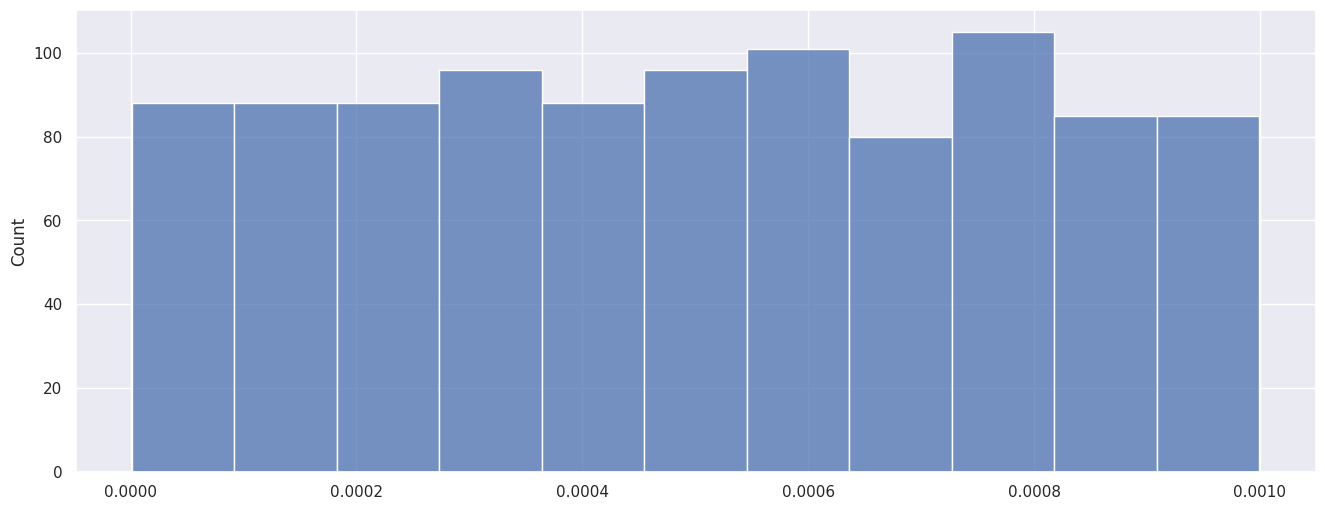

In [191]:
# Exploring a range of alpha values
#alphas = np.logspace(-4, 4, 100)
alphas = np.random.uniform(0,1,1000)/1000
sns.histplot(alphas)

Entrenemos varios modelos con las diferentes alphas y comparemos, y usemos la metrica `RMSE`

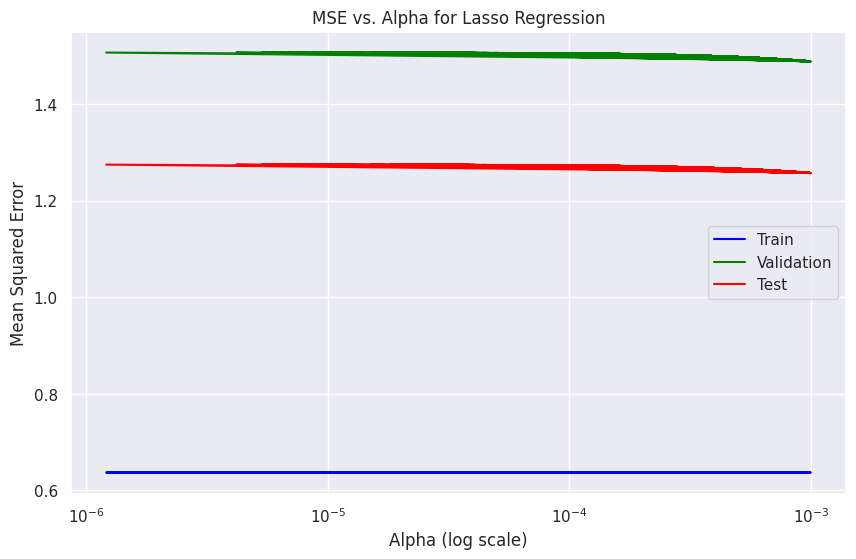

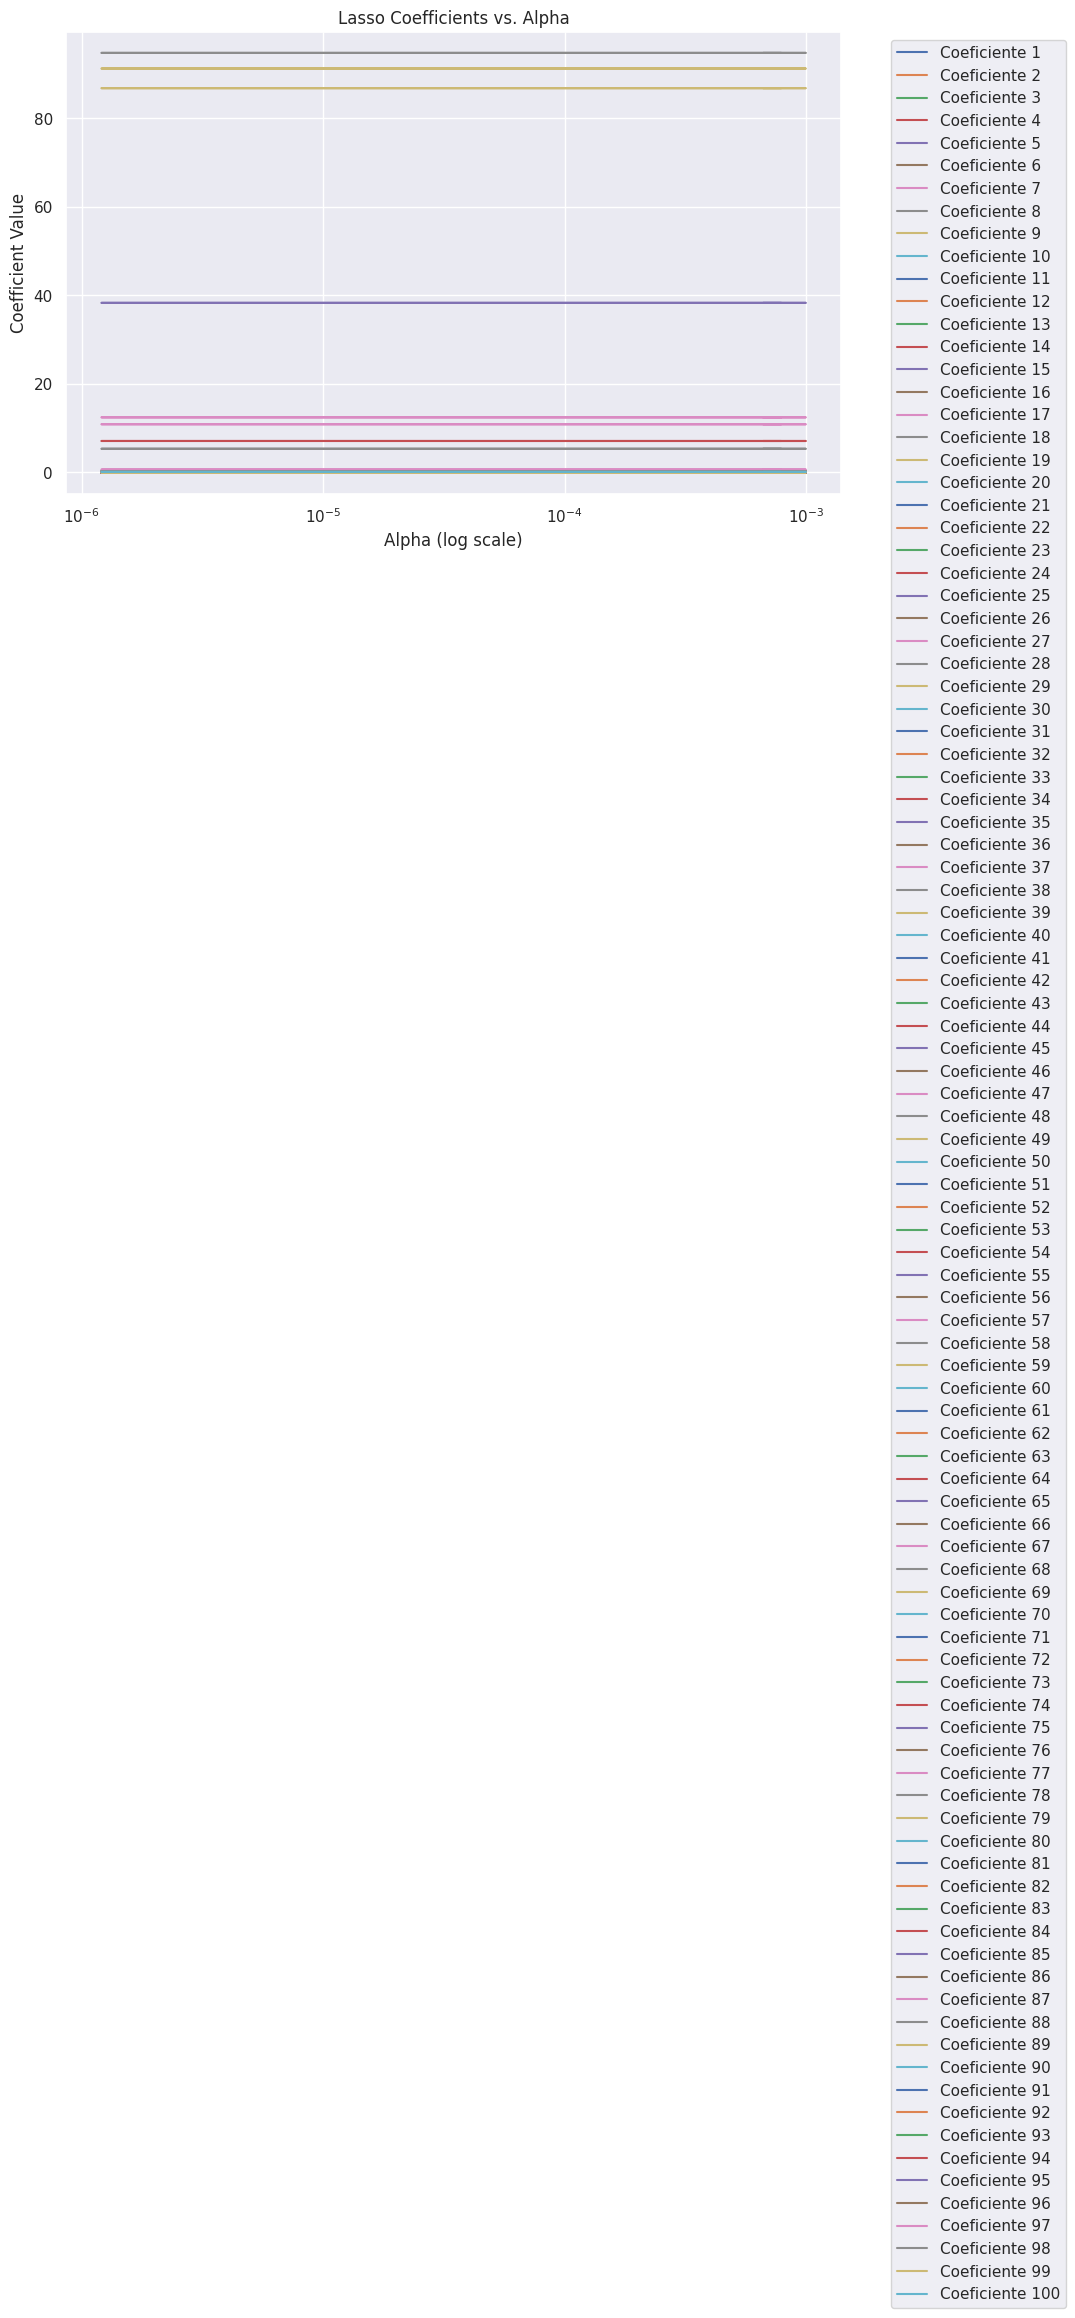

In [192]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
train_errors, val_errors, test_errors = [], [], []

coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    
    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)
    
    # Almacenamos los coeficientes
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Plotting MSEs against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Train', color='blue')
plt.plot(alphas, val_errors, label='Validation', color='green')
plt.plot(alphas, test_errors, label='Test', color='red')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.legend()
plt.grid(True)
plt.show()

# Plotting coefficients against alpha values
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}')

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


## Ejemplo mas complejo


In [193]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

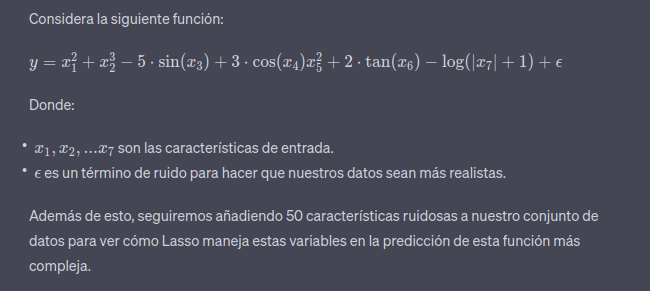

In [194]:
# Generando el conjunto de datos
np.random.seed(456)
n_samples = 10000

X = np.random.rand(n_samples, 7) * 100 - 5  # Valores aleatorios entre -50 y 50

# Elige alguna de las siguientes funciones

y = (X[:, 0]**2 + X[:, 1]**3 - 5 * np.sin(X[:, 2]) + 3 * np.cos(X[:, 3]) * X[:, 4]**2
     + 2 * np.tan(X[:, 5]) - np.log(np.abs(X[:, 6]) + 1))

# Añadiendo ruido gaussiano
y += np.random.normal(0, 1, size=y.shape)

Ahora vamos a annadir variables ruidosas o que no tienen que ver con nuestro modelo para ver como se comporta la regresion Lasso

In [196]:
# Añadiendo 10 características ruidosas
noisy_features = np.random.randn(n_samples, 5)
X = np.hstack([X, noisy_features])

In [197]:
# Dividiendo los datos en conjuntos de entrenamiento, validación y prueba
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [198]:
# Explorando una gama de valores de alpha
alphas = np.logspace(-6, 6, 1000)

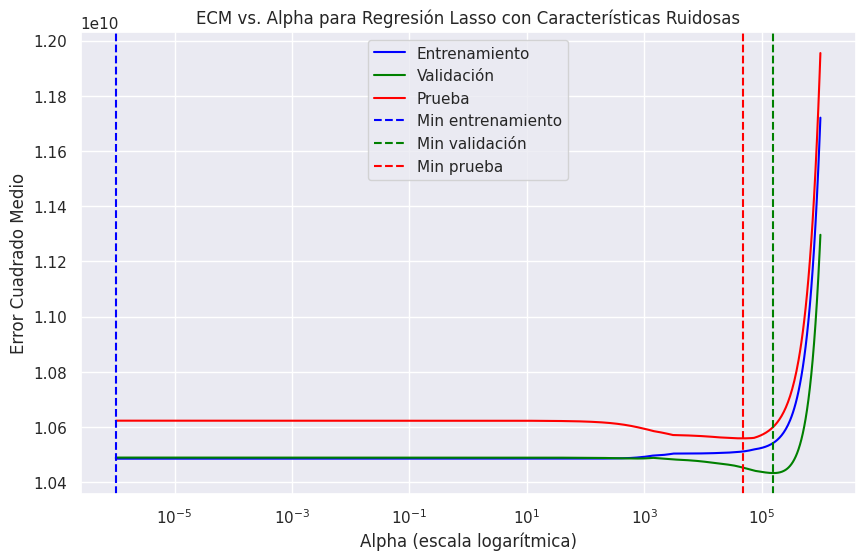

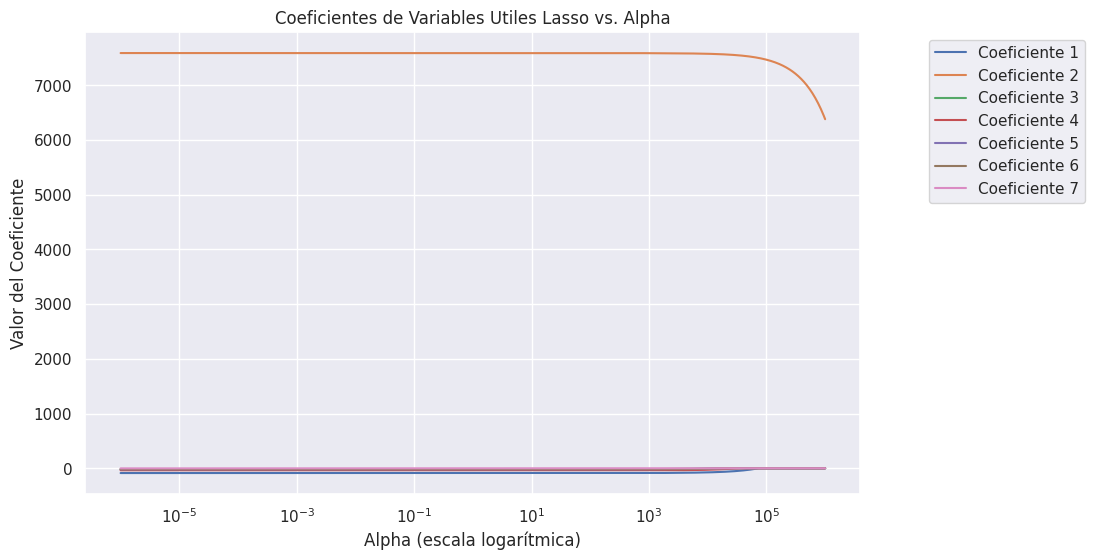

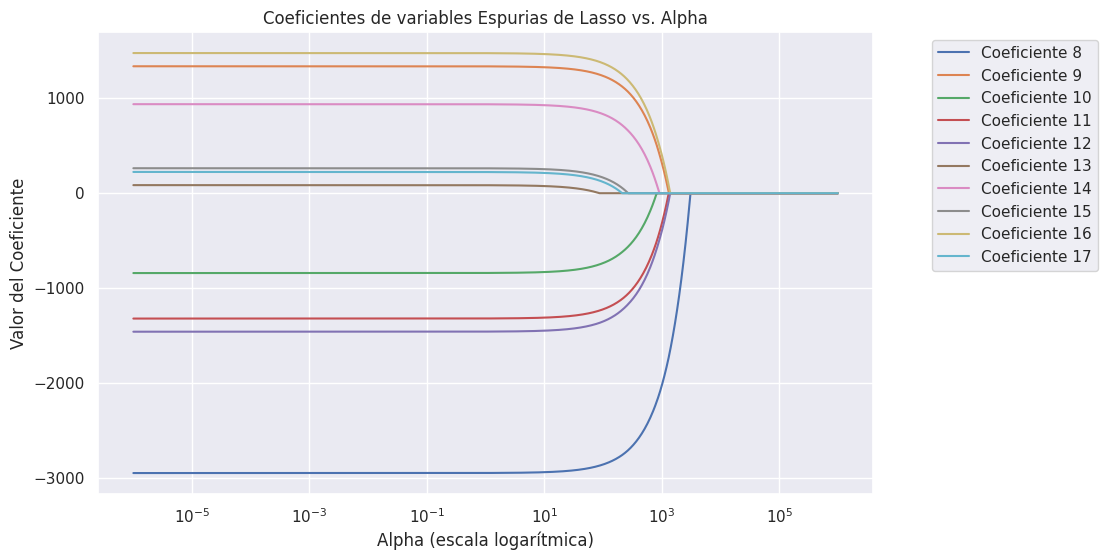

In [199]:
train_errors, val_errors, test_errors = [], [], []
train_stds, val_stds, test_stds = [], [], []

coefficients = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)

    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_std = np.std(y_train - y_train_pred)
    val_std = np.std(y_val - y_val_pred)
    test_std = np.std(y_test - y_test_pred)

    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)
    
    train_stds.append(train_std)
    val_stds.append(val_std)
    test_stds.append(test_std)
    
    # Almacenamos los coeficientes
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Encontrando los alphas que minimizan los errores
alpha_min_train = alphas[np.argmin(train_errors)]
alpha_min_val = alphas[np.argmin(val_errors)]
alpha_min_test = alphas[np.argmin(test_errors)]

# Graficando los errores MSE en función de los valores de alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Entrenamiento', color='blue')
plt.plot(alphas, val_errors, label='Validación', color='green')
plt.plot(alphas, test_errors, label='Prueba', color='red')

# Agregando las líneas que indican el mínimo error
plt.axvline(x=alpha_min_train, color='blue', linestyle='--', label='Min entrenamiento')
plt.axvline(x=alpha_min_val, color='green', linestyle='--', label='Min validación')
plt.axvline(x=alpha_min_test, color='red', linestyle='--', label='Min prueba')

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Error Cuadrado Medio')
plt.title('ECM vs. Alpha para Regresión Lasso con Características Ruidosas')
plt.legend()
plt.grid(True)
plt.show()

# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(0,7):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de Variables Utiles Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(7, coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de variables Espurias de Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

## Ridge

Hay que plantear el problema de Ridge en un lagrangeano. En este caso Ridge usa penalizacion $L^2$ osea cuadratica en vez de $L^1$ que usa Lasso (valor absoluto). Esto proboca un comportamiento en donde los coeficientes no se hacen cero, aunque tienden a cero. En Lasso lo coeficientes si se pueden hacer cero.

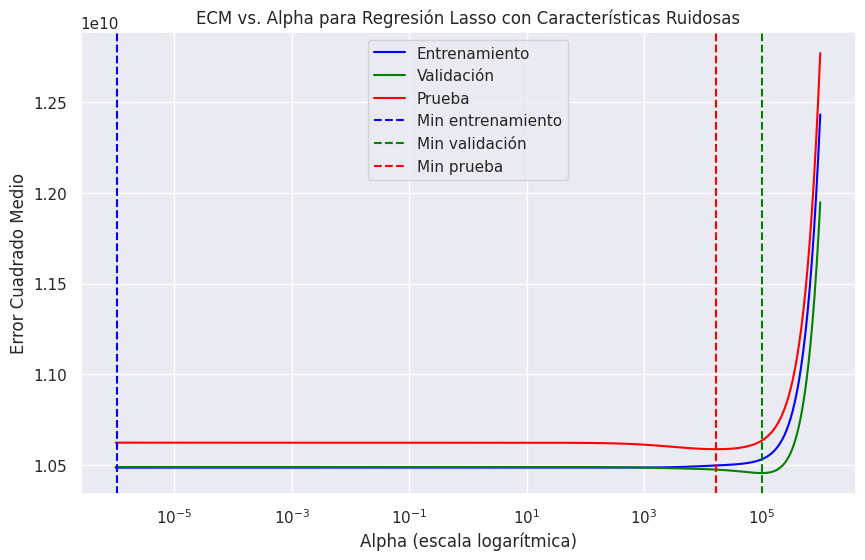

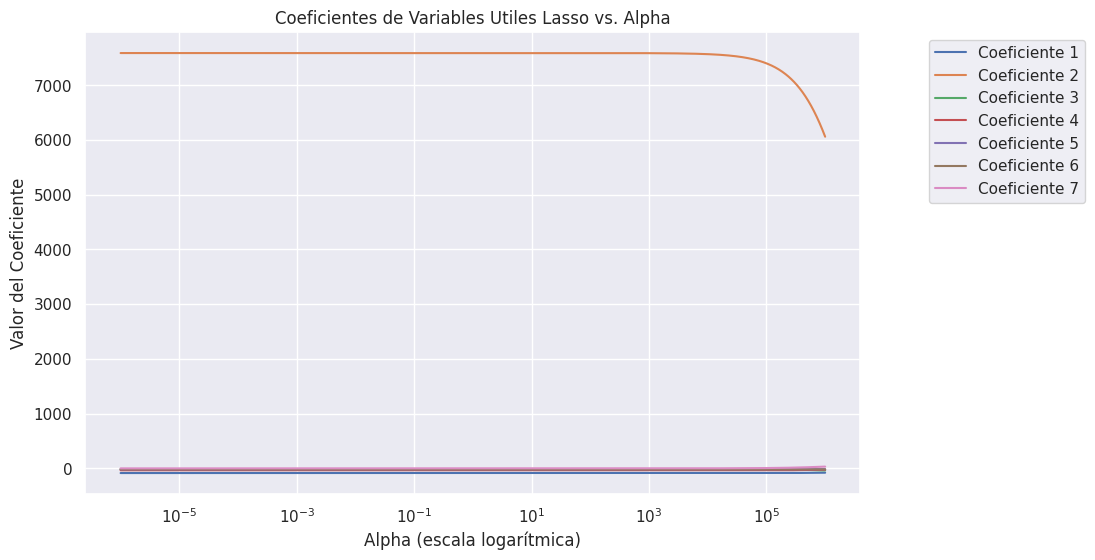

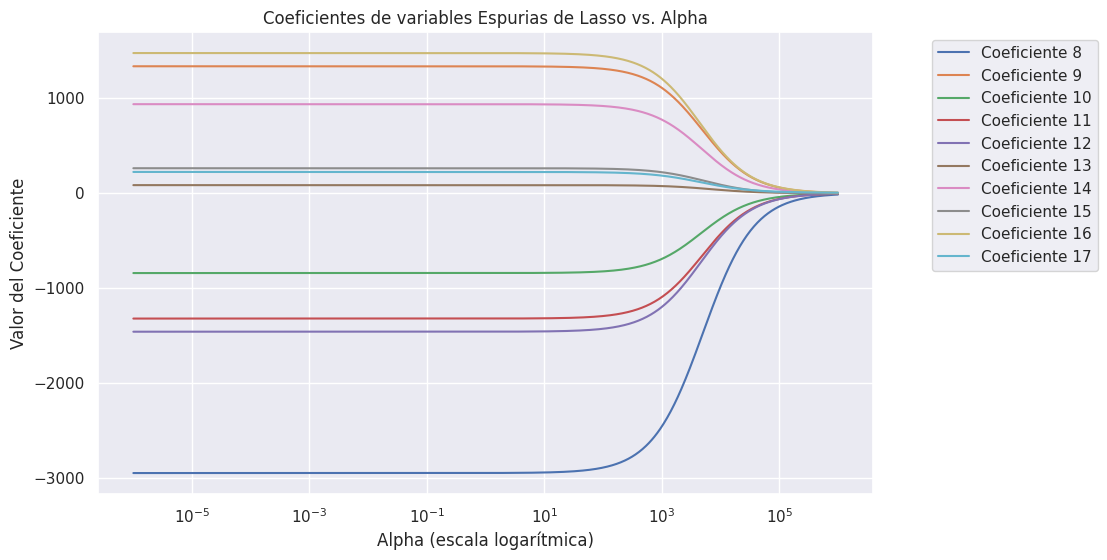

In [200]:
from sklearn.linear_model import Ridge
train_errors, val_errors, test_errors = [], [], []
train_stds, val_stds, test_stds = [], [], []

coefficients = []

for alpha in alphas:
    lasso = Ridge(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)

    y_train_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)
    y_test_pred = lasso.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_std = np.std(y_train - y_train_pred)
    val_std = np.std(y_val - y_val_pred)
    test_std = np.std(y_test - y_test_pred)

    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)
    
    train_stds.append(train_std)
    val_stds.append(val_std)
    test_stds.append(test_std)
    
    # Almacenamos los coeficientes
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

# Encontrando los alphas que minimizan los errores
alpha_min_train = alphas[np.argmin(train_errors)]
alpha_min_val = alphas[np.argmin(val_errors)]
alpha_min_test = alphas[np.argmin(test_errors)]

# Graficando los errores MSE en función de los valores de alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Entrenamiento', color='blue')
plt.plot(alphas, val_errors, label='Validación', color='green')
plt.plot(alphas, test_errors, label='Prueba', color='red')

# Agregando las líneas que indican el mínimo error
plt.axvline(x=alpha_min_train, color='blue', linestyle='--', label='Min entrenamiento')
plt.axvline(x=alpha_min_val, color='green', linestyle='--', label='Min validación')
plt.axvline(x=alpha_min_test, color='red', linestyle='--', label='Min prueba')

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Error Cuadrado Medio')
plt.title('ECM vs. Alpha para Regresión Lasso con Características Ruidosas')
plt.legend()
plt.grid(True)
plt.show()

# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(0,7):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de Variables Utiles Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


# Graficando coeficientes en función de los valores de alpha
plt.figure(figsize=(10, 6))
for i in range(7, coefficients.shape[1]):
    plt.plot(alphas, coefficients[:, i], label=f'Coeficiente {i+1}') # Limitar leyendas para visibilidad

plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Valor del Coeficiente')
plt.title('Coeficientes de variables Espurias de Lasso vs. Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()


# Tarea-Examen (**Valdra 50 puntos de tareas**)

1. Estudia bien que es el paradigma de train,validation y test
2. Estudia bien que es regularizacion, penalizacion, ridge, lasso
3. Asegurate de ser capaz de plantear un lagrangeano dado un problema de machine learning.
   1. Funcion objetivo, y coefficientes lambda aplicados a restricciones
   2. Colocarlo en una funcion
   3. Entender con que se eligen los parametros
   4. Entender con que se eligen los hyperparametros
   5. Como se plantean los hyperparametros con los que se van a buscar
   6. Entender que apsa si no exisitera el conjunto de validacion
   7. Cuantas veces se entrena dado el numero de hyperparametros propuestos
4. Juega con le notebook para entender la intuicion de lo que esta pasando
   1. Entender el problema de optimizacion
   2. Entender que esta pasando con los coeficientes cuando la penalizacion aumenta, entender su dinamica.

Piensa en que situaciones puedes usar Lasso y en que otras puedes usar Ridge

La siguiente clase sin uso de computadora, en papel y lapiz al inicio planteare un problema de machine learning para un modelo nuevo. Debes ser capaz de plantear el lagrangeano de dicho problema pues tendra un nuevo estilo de regularizacion. **Valdra 50 puntos de tareas**. El examen sera muy rapido, pues sera una serie de preguntas sencillas basadas en los conceptos que hemos visto en clase y plantear un lagrangeno (no tienes que saber resolver el lagrangeano solo plantearlo)